### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_large_kernel_lower_learning_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [269]:
batch_size = 32
target_size = (512,384)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

hd_datagen = ImageDataGenerator(rescale=1./255)

holdout_generator = hd_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       shuffle=False)

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [4]:
model=Sequential()

model.add(Conv2D(32, (7,7), strides=4, padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)


opt = keras.optimizers.Adam(learning_rate=.0001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 96, 32)       4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 96, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 47, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 11, 128)       0

In [5]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch_large_kernel_lower_learning.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 1000,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/1000
61/61 [==============================] - 145s 2s/step - loss: 1.6145 - accuracy: 0.3541 - val_loss: 1.7232 - val_accuracy: 0.2448
Epoch 2/1000
61/61 [==============================] - 140s 2s/step - loss: 1.2508 - accuracy: 0.5450 - val_loss: 1.6768 - val_accuracy: 0.3274
Epoch 3/1000
61/61 [==============================] - 139s 2s/step - loss: 1.1420 - accuracy: 0.5554 - val_loss: 1.6303 - val_accuracy: 0.3717
Epoch 4/1000
61/61 [==============================] - 137s 2s/step - loss: 1.0730 - accuracy: 0.6094 - val_loss: 1.5741 - val_accuracy: 0.3569
Epoch 5/1000
61/61 [==============================] - 141s 2s/step - loss: 1.0442 - accuracy: 0.6199 - val_loss: 1.4583 - val_accuracy: 0.4631
Epoch 6/1000
61/61 [==============================] - 140s 2s/step - loss: 0.9522 - accuracy: 0.6414 - val_loss: 1.4542 - val_accuracy: 0.3982
Epoch 7/1000
61/61 [==============================] - 138s 2s/step - loss: 0.8878 - accuracy: 0.6604 - val_loss: 1.3447 - val_accuracy: 0.4779

In [244]:
score = model.evaluate(holdout_generator
                       , verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.8366534113883972


In [ ]:
max()

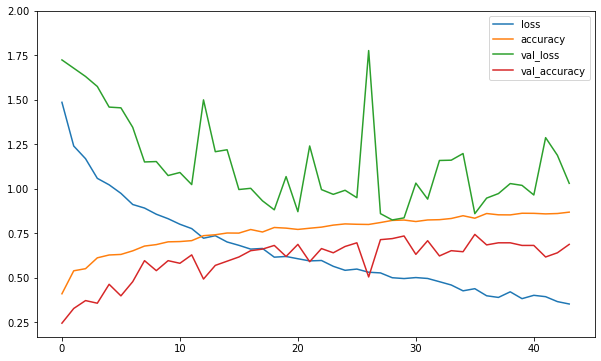

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=2)
plt.legend();

In [10]:
max(history.history['val_accuracy'])

0.7433628439903259

In [71]:
batch = next(holdout_generator)

In [72]:
batch[1]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [289]:
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns

In [210]:
def show_incorrect_batch_predictions(model, batch, label_dict):
    probs = model.predict(batch[0])
    predictions = np.argmax(probs, axis=1)
    target = np.argmax(batch[1], axis=1)
    incorrect = np.where(predictions != target)
    top3_idx = np.argsort(probs, axis=1)[:,-1:-4:-1]
    fig, axs = plt.subplots(len(incorrect[0]), 1, figsize=(9, 6*len(incorrect[0])))
    for idx, image in enumerate(incorrect[0]):
        axs[idx].imshow(batch[0][image])
        axs[idx].axis('off')
        axs[idx].set_title(f'Target: {label_dict[target[image]]}')
        textstr = f'''Top 3 Probabilities: \n 1. {label_dict[top3_idx[image, 0]]:}: {probs[image, top3_idx[image, 0]]:.2f} \n 2. {label_dict[top3_idx[image, 1]]}: {probs[image, top3_idx[image, 1]]:.2f} \n 3. {label_dict[top3_idx[image, 2]]}: {probs[image, top3_idx[image, 2]]:.2f}'''
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs[idx].text(1.2, 0.66, textstr, transform=axs[idx].transAxes, fontsize=14, va='center', ha='left', bbox=props)
    fig.tight_layout();
    
plt.rcParams.update({'font.size': 12})

In [222]:
batch1 = next(holdout_generator)

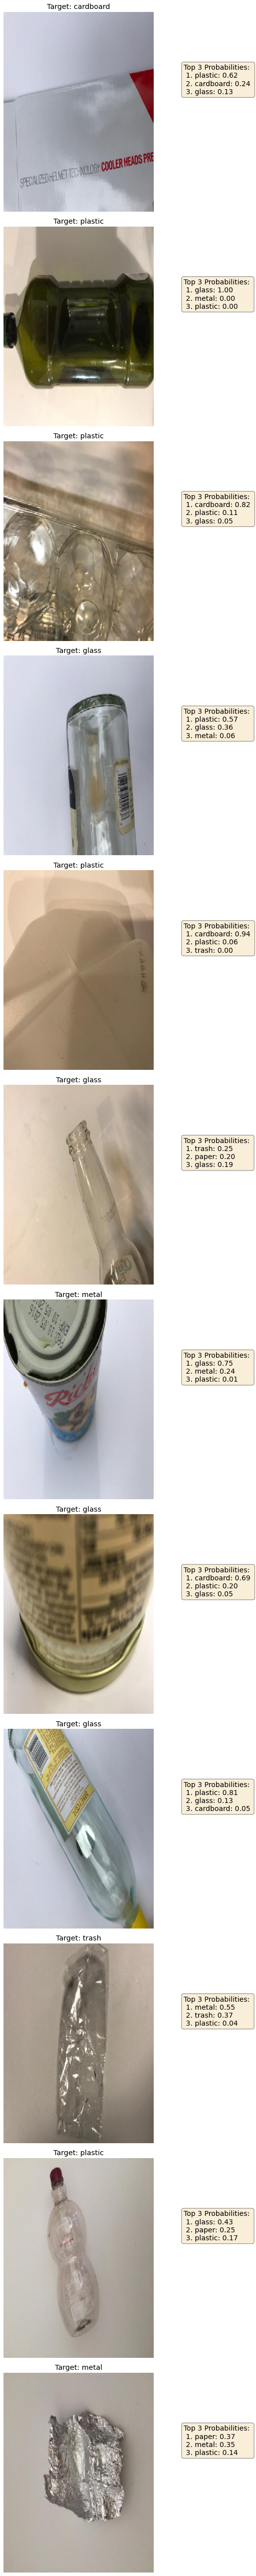

In [223]:
show_incorrect_batch_predictions(model, batch1, labels)

In [239]:
preds = np.argmax(model.predict(holdout_generator), axis=1)

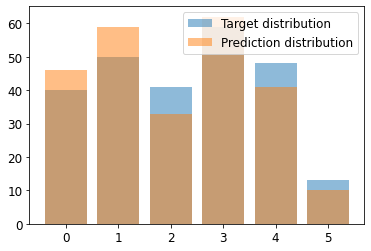

In [240]:
target_dist = Counter(holdout_generator.labels)
prediction_dist = Counter(preds)

plt.bar(list(target_dist.keys()), list(target_dist.values()), alpha=0.5, label='Target distribution')
plt.bar(list(prediction_dist.keys()), list(prediction_dist.values()), alpha=0.5, label='Prediction distribution')
plt.legend();

In [274]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [272]:
y_pred = np.argmax(model.predict(holdout_generator), axis=1)

In [271]:
holdout_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [283]:
con_mat = confusion_matrix(holdout_generator.classes, y_pred)

In [284]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

In [285]:
con_mat_norm

array([[0.98, 0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.02, 0.88, 0.  , 0.  , 0.08, 0.02],
       [0.  , 0.17, 0.68, 0.07, 0.05, 0.02],
       [0.02, 0.02, 0.  , 0.97, 0.  , 0.  ],
       [0.08, 0.12, 0.04, 0.04, 0.71, 0.  ],
       [0.08, 0.08, 0.23, 0.  , 0.  , 0.62]])

In [287]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [288]:
con_mat_norm_df = pd.DataFrame(con_mat_norm, index=labels, columns=labels)
con_mat_norm_df

,cardboard,glass,metal,paper,plastic,trash
cardboard,0.98,0.00,0.00,0.00,0.02,0.00
glass,0.02,0.88,0.00,0.00,0.08,0.02
metal,0.00,0.17,0.68,0.07,0.05,0.02
paper,0.02,0.02,0.00,0.97,0.00,0.00
plastic,0.08,0.12,0.04,0.04,0.71,0.00
trash,0.08,0.08,0.23,0.00,0.00,0.62


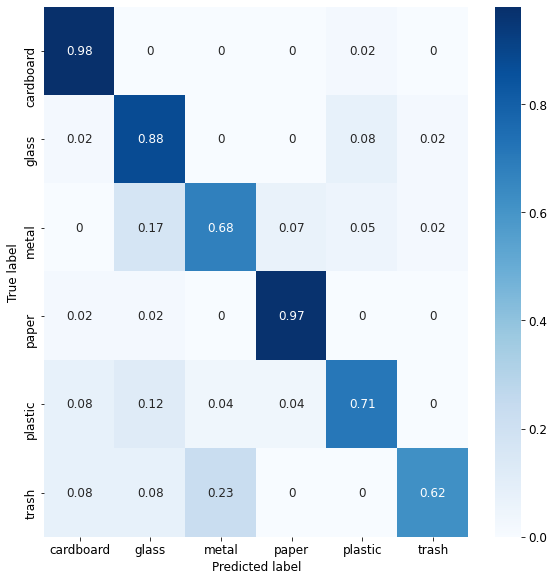

In [291]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [293]:
print(classification_report(holdout_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

   cardboard       0.85      0.97      0.91        40
       glass       0.75      0.88      0.81        50
       metal       0.85      0.68      0.76        41
       paper       0.92      0.97      0.94        59
     plastic       0.83      0.71      0.76        48
       trash       0.80      0.62      0.70        13

    accuracy                           0.84       251
   macro avg       0.83      0.80      0.81       251
weighted avg       0.84      0.84      0.83       251

